In [1]:
import pandas as pd
import os
from datetime import date, timedelta
import datetime
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
# grid search sarima hyperparameters for monthly mean temp dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sktime.performance_metrics.forecasting import mean_absolute_error


In [2]:
ROOT_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))
cln_pkl_loc = os.path.join(ROOT_DIR, 'data','AAcleaned.pkl')
fut_pkl_loc = os.path.join(ROOT_DIR, 'data','data','weatherAAtest.pkl')

In [3]:
#pip install sktime

In [4]:
df=pd.read_pickle(cln_pkl_loc)
dfft=pd.read_pickle(fut_pkl_loc)


In [5]:
df.drop(columns=['NaNcount','NaNmax'], inplace=True)
df=df.loc[:'2022-08-31 23:00:00']

In [8]:
df=pd.concat([df,dfft])
df

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2006-01-01 00:00:00,1.0,-1.1,86.0,NaN,240.0,14.8,NaN
2006-01-01 01:00:00,1.1,-0.1,92.0,0.0,240.0,14.8,1009.0
2006-01-01 02:00:00,0.6,0.0,96.0,NaN,250.0,13.0,1009.5
2006-01-01 03:00:00,1.1,-0.1,92.0,NaN,250.0,13.0,1009.6
2006-01-01 04:00:00,1.1,-0.7,88.0,NaN,250.0,14.8,1010.5
...,...,...,...,...,...,...,...
2022-10-15 19:00:00,11.1,-0.1,46.0,0.0,210.0,24.1,1013.2
2022-10-15 20:00:00,11.1,-0.1,46.0,0.0,220.0,24.1,1013.7
2022-10-15 21:00:00,10.0,-0.5,48.0,0.0,220.0,20.5,1013.8


### Building future time range for output

In [9]:
time_range = pd.date_range('2022-09-01 00:00:00', '2022-10-15 23:00:00', freq='H') ##creating time range
time_range=pd.DataFrame(time_range, columns=['time'])
time_range.set_index('time',inplace=True)

In [13]:
def sarima_forecast(history, config,delta):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False, freq='H')
    #model.ssm.stability_force_symmetry=True
    #print(model.ssm.stability_force_symmetry)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    #yhat=history.iloc[-1:].index[0]
    start_predict=history.iloc[-1:].index[0]+timedelta(hours=1)
    end_predict=start_predict+timedelta(hours=delta-1)
    yhat = model_fit.predict(start_predict, end_predict)
    return yhat

#Loops from original Sarima detection - Don't run takes forever
def loopsarima(df,time_range, col): #function takes in a DF(with timediff column) and how far back you want to adjust, creates rows for all missing values and adds them in
    for ind in df.index:
        #print(df.loc[ind]['NaNmax'])
        if df.loc[ind]['NaNmax']==0:
            None
        else:
            hs=df.loc[ind].name-timedelta(days=5) #building the SARIMAX back 30 days for every missing value
            minind=df.index.min()
            if minind>hs: #checks to see if value is in the first 30 days, uses first value if so
                hs=minind
            df_hs=df.loc[hs:ind]
            config=[(1,0,0),(0,1,0,24),'n'] #found from the first SARIMAX all possible scans
            #config=[(2, 0, 2), (0, 1, 0, 24), 't']
            try:
            # never show warnings when grid searching, too noisy
                with catch_warnings():
                    filterwarnings("ignore")
                    yhat=sarima_forecast(df_hs[col],config,int(df.loc[ind]['NaNmax']))
            except:
                error = None
            yhat.rename('temp',inplace=True)
            yhat = pd.DataFrame(yhat)
            df.at[ind,'NaNmax']=0 #changing all values to 0 so SARIMA function isn't called for each value
            yhat['NaNmax']=0
            df.update(yhat)
    return df

#df2=loopsarima(df,time_range.loc['2021-09-01 00:00:00':'2022-09-01 23:00:00'], 'temp')
sarima_base_results = sarima_forecast(df.loc['2021-08-01 00:00:00':'2022-08-31 23:00:00']['temp'],[(0, 1, 0), (1, 1, 2, 24), 'c'],1080)

C:\Users\paull\Anaconda32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [14]:
sarima_base_results.to_csv('SARIMA_Results.csv')

In [12]:
filterwarnings("ignore")
def buildfuture24(df, tr, col, config, delta):
    tr[col]=np.nan
    tr[col+'actual']=np.nan
    for ind in tqdm(tr.index):
        st=ind-timedelta(days=30)
        end=ind-timedelta(hours=delta) #going back 24 hours to make the prediction match our other techniques
        filterwarnings("ignore")
        yhat = sarima_forecast(df.loc[st:end][col],config,delta)
        tr.at[ind,col]=yhat.iloc[-1]
        tr.at[ind,col+'actual']=df.loc[ind][col]
    return tr

test=buildfuture24(df, time_range, 'temp', [(0, 1, 0), (1, 1, 2, 24), 't'], 24)


100%|██████████| 1080/1080 [1:56:00<00:00,  6.44s/it] 


In [33]:
test2=sarima_forecast(df.loc['2021-08-31 23:00:00':'2022-08-31 23:00:00']['temp'],[(0, 1, 0), (1, 1, 2, 24), 'c'],696 )

In [13]:
test.to_csv('SARAMA_Results')

In [22]:
mean_absolute_error(test['temp'], test['tempactual'])

4.100512856816979

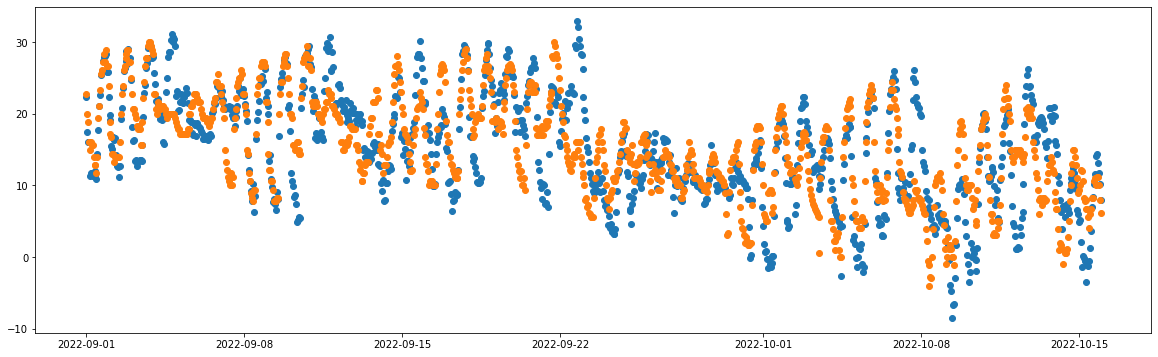

In [17]:
x= test.index
y= test['temp']
y2 = test['tempactual']
#y3=test2.values
figure(figsize=(20,6))
plt.scatter(x,y)
plt.scatter(x,y2)
#plt.scatter(x,y3)
plt.show()



In [30]:
test2=sarima_forecast(df.loc[:'2022-08-31 23:00:00'], time_range, 'temp', [(0, 1, 0), (1, 1, 2, 24), 'c'], 24)

4.522543357030884

In [29]:
test.loc['2022-09-20 00:00:00':'2022-09-22 00:00:00']


,temp,tempactual
time,,
2022-09-20 00:00:00,17.814110,19.0
2022-09-20 01:00:00,21.171312,15.0
2022-09-20 02:00:00,18.673413,13.9
2022-09-20 03:00:00,19.803193,12.8
2022-09-20 04:00:00,20.131829,12.0
2022-09-20 05:00:00,19.998711,12.0
2022-09-20 06:00:00,17.672016,11.0
2022-09-20 07:00:00,19.027793,11.0
2022-09-20 08:00:00,19.163926,10.0


### Best scoring models
Model[[(2, 0, 1), (1, 1, 2, 24), 't']] 1.096, Model[[(1, 0, 0), (1, 1, 2, 24), 'c']] 1.099, Model[[(1, 1, 0), (1, 1, 2, 24), 'n']] 1.093, Model[[(0, 1, 0), (1, 1, 2, 24), 'c']] 1.093
Model[[(2, 1, 1), (1, 1, 2, 24), 'n']] 1.086 

In [14]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(test['temp'], test['tempactual'])

153.0756202966765

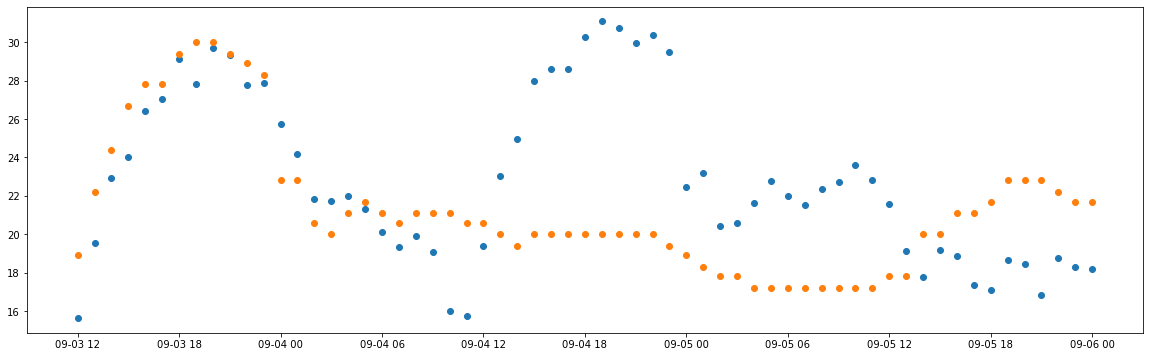

In [15]:
x= test.loc['2022-09-03 12:00:00':'2022-09-06 00:00:00'].index
y= test.loc['2022-09-03 12:00:00':'2022-09-06 00:00:00']['temp']
y2 = test.loc['2022-09-03 12:00:00':'2022-09-06 00:00:00']['tempactual']
figure(figsize=(20,6))
plt.scatter(x,y)
plt.scatter(x,y2)
plt.show()

In [129]:
test.loc['2022-09-03 12:00:00':'2022-09-06 00:00:00'].index

DatetimeIndex(['2022-09-03 12:00:00', '2022-09-03 13:00:00',
               '2022-09-03 14:00:00', '2022-09-03 15:00:00',
               '2022-09-03 16:00:00', '2022-09-03 17:00:00',
               '2022-09-03 18:00:00', '2022-09-03 19:00:00',
               '2022-09-03 20:00:00', '2022-09-03 21:00:00',
               '2022-09-03 22:00:00', '2022-09-03 23:00:00',
               '2022-09-04 00:00:00', '2022-09-04 01:00:00',
               '2022-09-04 02:00:00', '2022-09-04 03:00:00',
               '2022-09-04 04:00:00', '2022-09-04 05:00:00',
               '2022-09-04 06:00:00', '2022-09-04 07:00:00',
               '2022-09-04 08:00:00', '2022-09-04 09:00:00',
               '2022-09-04 10:00:00', '2022-09-04 11:00:00',
               '2022-09-04 12:00:00', '2022-09-04 13:00:00',
               '2022-09-04 14:00:00', '2022-09-04 15:00:00',
               '2022-09-04 16:00:00', '2022-09-04 17:00:00',
               '2022-09-04 18:00:00', '2022-09-04 19:00:00',
               '2022-09-